Filter 1D profile after I have extracted it with transect tool <br>

unfiltering the unwrapped data 
filter, unwrap, then unfilter

In [1]:
# import stuff
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from datetime import datetime
from datetime import timedelta
from dateutil import parser
import numpy as np
from scipy.ndimage import uniform_filter, gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from extract_transect import extract_transect
%matplotlib  widget

Create synthetic dataset. A sine wave.

In [2]:
# fixing random state for reproducibility
np.random.seed(19680805)

# sine wave with noise added 
a = 6    # amplitude 
b = 0.05  # period 
c = 2*np.pi    # phase shift
x = np.arange(0,100,1)
noise=np.random.randn(100)*0.6
y = a*np.sin(b*x + c)
ynoise=y+noise

# make it complex with mags=1
data=np.exp(1j*ynoise)
phs=np.angle(data)

Plot the synthetic data, true data (sine wave), data with noise, and wrapped data 

/tmp/ipykernel_23583/3925315353.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(7.5, 5))


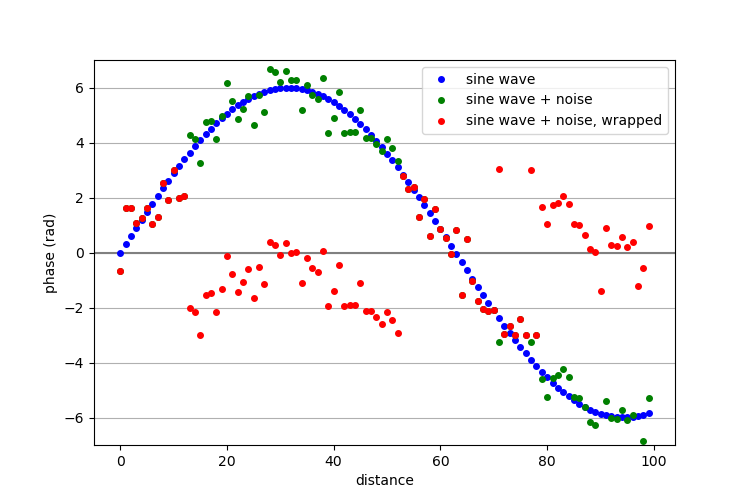

In [30]:
plt.figure(figsize=(7.5, 5))
# plt.axhline(y=np.pi,c='gray')
# plt.axhline(y=-np.pi,c='gray')
plt.axhline(y=0,c='gray')
plt.plot(x,y,'b.',markersize=8,label='sine wave')
plt.plot(x,ynoise,'g.',markersize=8,label='sine wave + noise')
plt.plot(x,phs,'r.',markersize=8,label='sine wave + noise, wrapped')
#plt.plot(x,phs,'r.',markersize=8,label='raw data, wrapped')
plt.xlabel('distance'); plt.ylabel('phase (rad)')
plt.ylim([-7,7])
plt.legend(); plt.grid(axis='y')
plt.show()

Unwrap the unfiltered data to show that there will be errors with unwrapping noise 

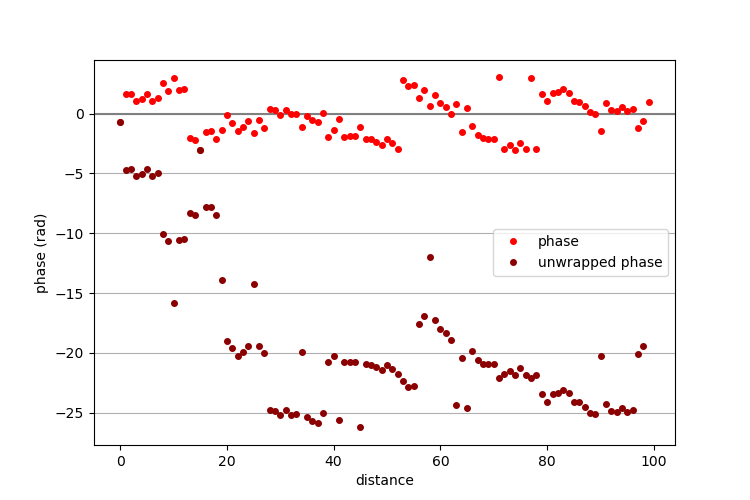

In [39]:
# unwrap the raw/noisy data, show that it's bad.
bad_unwrapped = np.ndarray(len(phs)-1,'float')

# start a counter 
count = 0;
for i in np.arange(len(phs)-1):
    bad_unwrapped[i] = phs[i]+count
    jump = (phs[i+1]-phs[i])
    if (np.abs(jump) > np.pi/4): 
        if (jump > 0):
            count -= 2*np.pi
        else:
            count += 2*np.pi

plt.figure(figsize=(7.5, 5))
# plt.axhline(y=np.pi,c='gray')
# plt.axhline(y=-np.pi,c='gray')
plt.axhline(y=0,c='gray')
plt.plot(x,phs,'r.',markersize=8,label='phase')
plt.plot(x[0:-1],bad_unwrapped,'.',color='darkred',markersize=8,label='unwrapped phase')
plt.xlabel('distance'); plt.ylabel('phase (rad)'); plt.grid(axis='y')
plt.legend(); #plt.ylim([-7,7])
plt.show()

Filter the data to then unwrap it.

In [4]:
# filter the data with gaussian? 
std = 1 # standard deviation 
filtDat1 = gaussian_filter(phs,std)

An example of filtering WRONG. This filtered imaginary numbers rather than the real and imag. parts separately.

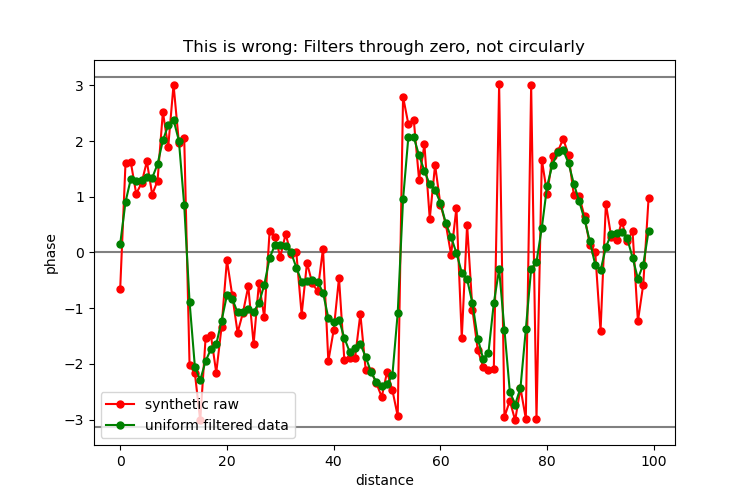

In [5]:
plt.figure(figsize=(7.5, 5))
plt.axhline(y=np.pi,c='gray')
plt.axhline(y=-np.pi,c='gray')
plt.axhline(y=0,c='gray')
plt.plot(x,phs,'-ro',markersize=5,label='synthetic raw')
plt.plot(x,filtDat1,'-go',markersize=5,label='uniform filtered data')
plt.xlabel('distance'); plt.ylabel('phase')
plt.legend()
plt.title('This is wrong: Filters through zero, not circularly')
plt.show()
# THIS IS AN EXAMPLE OF BAD FILTERING 
# we can see the values now go through zero and will make it challenging to unwrap
# so we need to filter in the complex domain 

Now filter it correctly. Separate real and imaginary parts, filter each, then combine them again.

In [6]:
# NOW filter it correctly 
std = 4   # standard deviation
# separate real and imaginary parts of data
re = np.real(data)
im = np.imag(data)
# filter the real/imag parts separately 
refilt = uniform_filter(re,std)
imfilt = uniform_filter(im,std)
datafilt = uniform_filter(data,std)
# put the filtered data back together 
filtDat = 1j*imfilt + refilt
# correlation is the new magnitude of filtered data
cor = np.real(filtDat)
filtPhs = np.angle(filtDat)

Plot the raw (wrapped) data and the filtered data.

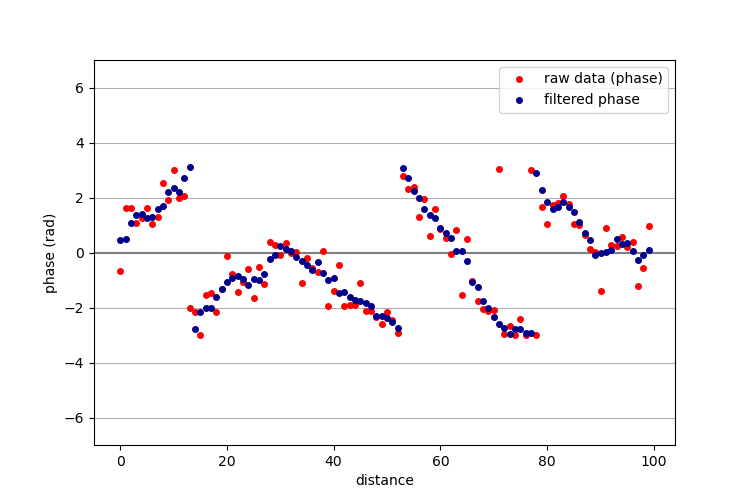

In [41]:
plt.figure(figsize=(7.5, 5))
# plt.axhline(y=np.pi,c='gray')
# plt.axhline(y=-np.pi,c='gray')
plt.axhline(y=0,c='gray')
plt.plot(x,phs,'r.',markersize=8,label='raw data (phase)')
plt.plot(x,filtPhs,'.',color='darkblue',markersize=8,label='filtered phase')
plt.xlabel('distance'); plt.ylabel('phase (rad)'); plt.grid(axis='y')
plt.legend(); plt.ylim([-7,7])
plt.show()

Now unwrap the filtered data to use in actual unwrapping.

In [43]:
# unwrap with simple algorithm 
unwrapped = np.ndarray(len(phs)-1,'float')

# start a counter 
count = 0;
for i in np.arange(len(phs)-1):
    unwrapped[i] = filtPhs[i]+count
    jump = (filtPhs[i+1]-filtPhs[i])
    if (np.abs(jump) > np.pi/4): 
        if (jump > 0):
            count -= 2*np.pi
        else:
            count += 2*np.pi

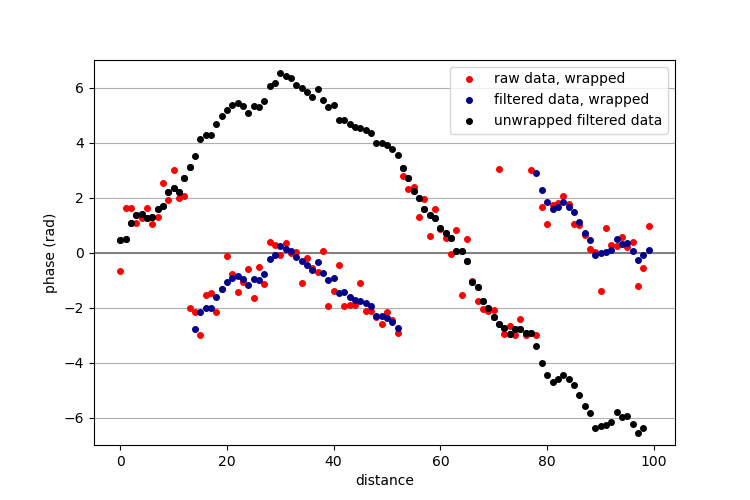

In [51]:
plt.figure(figsize=(7.5, 5))
# plt.axhline(y=np.pi,c='gray');plt.axhline(y=-np.pi,c='gray');plt.axhline(y=0,c='gray')
#plt.plot(x,y,'b.',markersize=8,label='synthetic data (sine wave), no noise')
plt.axhline(y=0,c='gray')
plt.plot(x,phs,'r.',markersize=8,label='raw data, wrapped')
plt.plot(x,np.angle(filtDat),'.',color='darkblue',markersize=8,label='filtered data, wrapped')
plt.plot(x[0:-1],unwrapped,'.k',markersize=8,label='unwrapped filtered data')
plt.xlabel('distance'); plt.ylabel('phase (rad)')
plt.legend(); plt.grid(axis='y'); plt.ylim([-7,7])
plt.show()

In [10]:
# add the difference back to the unfiltered version 
# difference between filtered unwrapped data and filtered unwrapped data 
dif = unwrapped - filtPhs[0:-1]
# ^will be entirely increments of 2pi 

# now add the difference back to the unfiltered data to unwrap it
difAdded = phs[0:-1] + dif 
#print(dif)

#compare difadded to unwrapped 
rem = np.mod(unwrapped-difAdded+np.pi,2*np.pi)-np.pi
# so if any of the remainders is more than 2pi, we only want what's leftover because it was improperly unwrapped
rem2 = unwrapped - rem

#KEEP plotting difadded to see which points we need to fix
# if I keep making filter bigger and bigger, will stop working 
# also won't work 100% of the time on like agricultural fields 

In [11]:
#print(rem)


In [12]:
print(np.shape(rem2))
print(np.shape(x))
print(rem2)
print(np.shape(x[0:-1]))

(99,)
(100,)
[-0.66285825  1.60649738  1.61601969  1.05658781  1.24215242  1.63499746
  1.04058275  1.2861304   2.52433532  1.89231353  3.01418545  1.97150839
  2.05432954  4.25979729  4.11417792  3.26746811  4.74281927  4.79703139
  4.12450308  4.95031673  6.14739794  5.51268015  4.84445888  5.20058717
  5.6763643   4.63879596  5.73869269  5.1204617   6.67160215  6.55773856
  6.2074624   6.61469712  6.25625708  6.28710608  5.16730411  6.09905446
  5.72694012  5.58939103  6.35429679  4.33206249  4.88818696  5.82705773
  4.34791519  4.38045494  4.38831027  5.18008755  4.17395555  4.15055046
  3.9381963   3.6899871   4.13560339  3.8144482   3.34518974  2.79658271
  2.30058995  2.38737621  1.30570893  1.93991344  0.60478134  1.57212434
  0.86043748  0.51450124 -0.03781801  0.80205943 -1.53718309  0.49908326
 -1.02532577 -1.75007741 -2.04845605 -2.11552316 -2.1001995  -3.26292715
 -2.95158005 -2.66021597 -3.01370169 -2.4348959  -2.98367888 -3.27086636
 -2.98928807 -4.61695468 -5.24060562 -

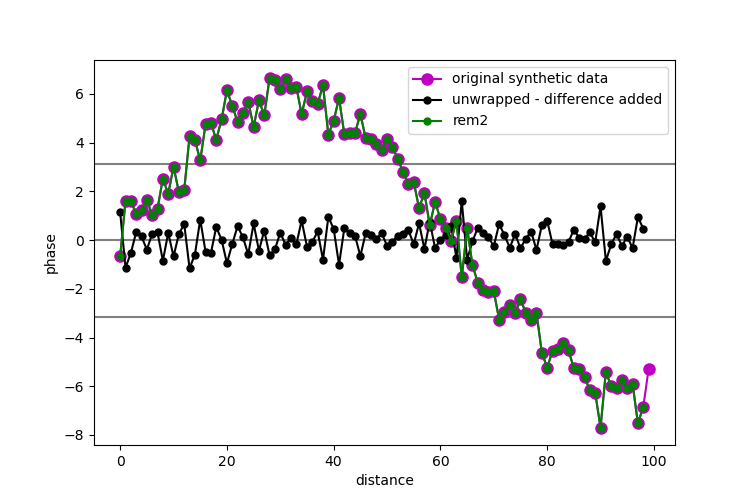

In [13]:
plt.figure(figsize=(7.5, 5))
plt.axhline(y=np.pi,c='gray');plt.axhline(y=-np.pi,c='gray');plt.axhline(y=0,c='gray')
plt.plot(x,ynoise,'-mo',markersize=8,label='original synthetic data')
#plt.plot(x,phs,'-ro',markersize=5,label='synthetic raw, wrapped')
#plt.plot(x,filtPhs,'-go',markersize=5,label='uniform filtered data, wrapped')
#plt.plot(x[0:-1],unwrapped,'-bo',markersize=5,label='unwrapped filtered data')
plt.plot(x[0:-1],rem,'-ko',markersize=5,label='unwrapped - difference added')
plt.plot(x[0:-1],rem2,'-go',markersize=5,label='rem2')
plt.xlabel('distance'); plt.ylabel('phase')
plt.legend()
plt.show()

modulus of (stuff - pi, 2pi)-pi
gives the one point being different 
shifts it and then shifts it back 

modulus 0-1 

Now do it with real data from extracting transect: 

In [14]:
# %load filter_1D_profile_and_unwrap.py
# defining a function to read in a 1D profile of data, filter it, unwrap it, then add the phase jumps back to the raw data
#
# inputs are:
#     data is an array of complex values with first row as X values, second row as Y values 
#     std is the standard deviation we use to filter the data 
#     cutoff is the phase change to use as a cutoff for unwrapping
#
# output is array of complex values that are now unwrapped
# with first row as X values, second row as Y values
# (each has one less data point than the input)

# for more detailed + commented code, see filter_1D_profile_and_unwrap.ipynb
# to use this function in a notebook, use the following line of code to import it:
#     %load filter_1D_profile_and_unwrap.py

def unwrap_1D(data, std, cutoff):
    import numpy as np
    from scipy.ndimage import uniform_filter
    x = data[0].real
    y = data[1]
    numPts = len(y)
    re = np.real(y)
    im = np.imag(y)
    phs = np.angle(y)
    refilt = uniform_filter(re,std)
    imfilt = uniform_filter(im,std)
    filtDat = 1j*imfilt + refilt
    cor = np.real(filtDat)
    filtPhs = np.angle(filtDat)
    unwrapped = np.ndarray(len(phs)-1,'float')
    count = 0;
    for i in np.arange(len(phs)-1):
        unwrapped[i] = filtPhs[i]+count
        jump = filtPhs[i+1]-filtPhs[i]
        if (np.abs(jump) > cutoff): 
            if (jump > 0):
                count -= 2*np.pi
            else:
                count += 2*np.pi
    dif = unwrapped - filtPhs[0:-1]
    difAdded = phs[0:-1] + dif 
    rem = np.mod(unwrapped-difAdded+np.pi,2*np.pi)-np.pi
    rem2 = unwrapped - rem
    
    # to vstack, make them (1,n) dimensional 
    newX = x[0:-1]
    outputX = newX.reshape((1,numPts-1))
    outputY = rem2.reshape((1,numPts-1))
    output = np.vstack((outputX,outputY))
    return output


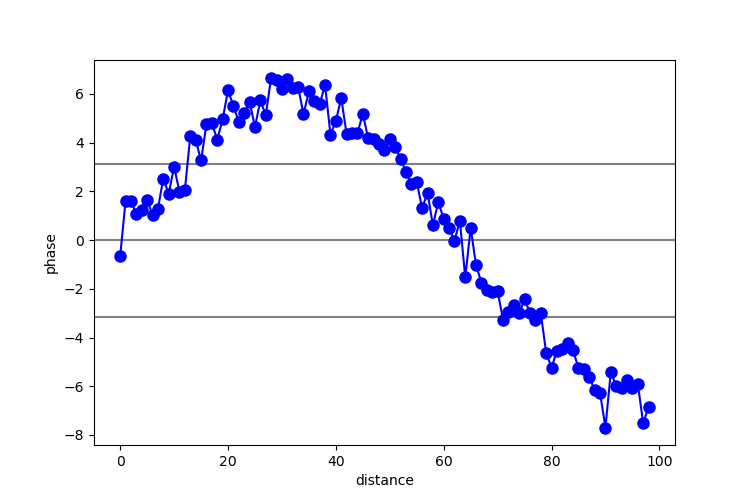

In [15]:
inputX = x.reshape((1,len(x)))
inputY = data.reshape((1,len(x)))
inputData = np.vstack((x,data))

test = unwrap_1D(inputData, 4, np.pi/4)
#print(test[0].real)
#print(test[1])

plt.figure(figsize=(7.5, 5))
plt.axhline(y=np.pi,c='gray');plt.axhline(y=-np.pi,c='gray');plt.axhline(y=0,c='gray')
plt.plot(np.real(test[0]),(test[1]),'-bo',markersize=8)
plt.xlabel('distance'); plt.ylabel('phase')
plt.show()

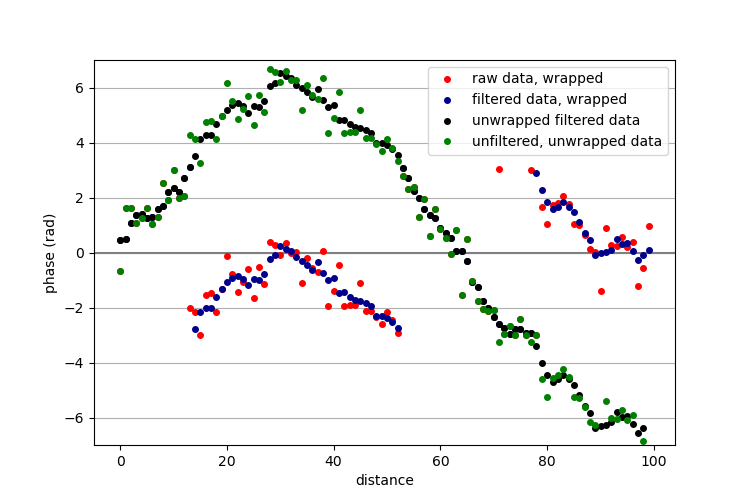

In [54]:
plt.figure(figsize=(7.5, 5))
# plt.axhline(y=np.pi,c='gray');plt.axhline(y=-np.pi,c='gray');plt.axhline(y=0,c='gray')
#plt.plot(x,y,'b.',markersize=8,label='synthetic data (sine wave), no noise')
plt.axhline(y=0,c='gray')
plt.plot(x,phs,'r.',markersize=8,label='raw data, wrapped')
plt.plot(x,np.angle(filtDat),'.',color='darkblue',markersize=8,label='filtered data, wrapped')
plt.plot(x[0:-1],unwrapped,'.k',markersize=8,label='unwrapped filtered data')
plt.plot(np.real(test[0]),(test[1]),'g.',markersize=8,label='unfiltered, unwrapped data')
plt.xlabel('distance'); plt.ylabel('phase (rad)')
plt.legend(); plt.grid(axis='y'); plt.ylim([-7,7])
plt.show()

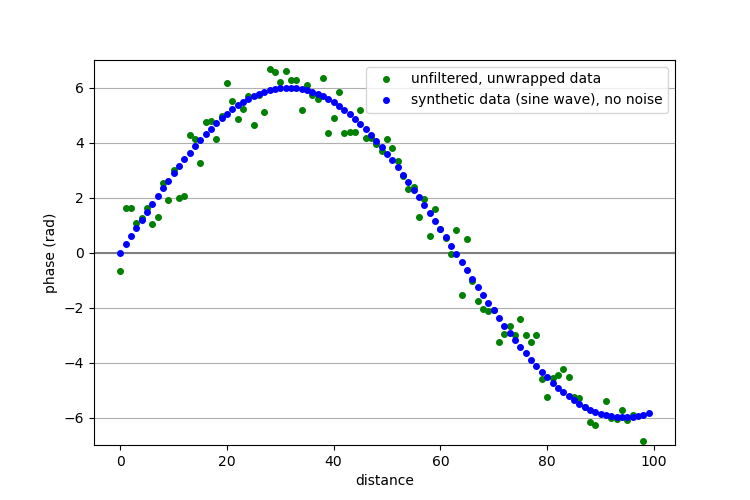

In [56]:
plt.figure(figsize=(7.5, 5))
plt.axhline(y=0,c='gray')
# plt.plot(x,phs,'r.',markersize=8,label='raw data, wrapped')
# plt.plot(x,np.angle(filtDat),'.',color='darkblue',markersize=8,label='filtered data, wrapped')
# plt.plot(x[0:-1],unwrapped,'.k',markersize=8,label='unwrapped filtered data')
plt.plot(np.real(test[0]),(test[1]),'g.',markersize=8,label='unfiltered, unwrapped data')
plt.plot(x,y,'b.',markersize=8,label='synthetic data (sine wave), no noise')
plt.xlabel('distance'); plt.ylabel('phase (rad)')
plt.legend(); plt.grid(axis='y'); plt.ylim([-7,7])
plt.show()

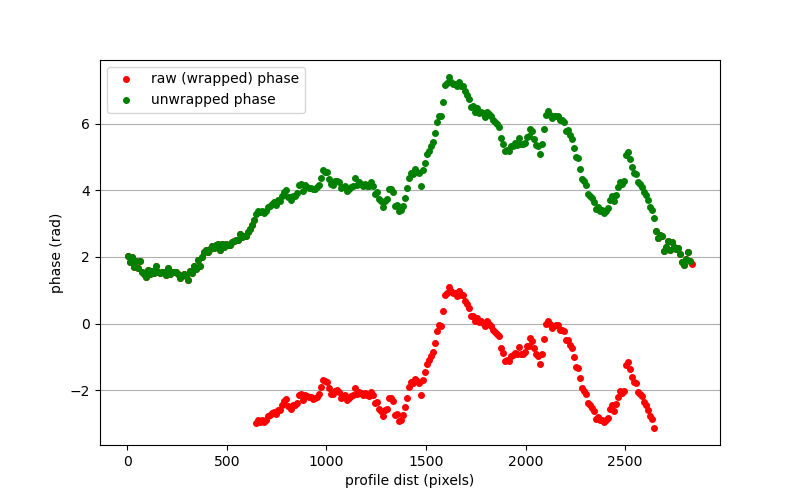

In [58]:
# try it on another dataset 

# set up an igram to use as the data array to input to function 
workdir = '/data/ocp4/LagunaSalada/'
cropdir='cropped_9000_1800_18000_3600/'
date1='20190112'
date2='20190124'

date1='20210928'
date2='20211004'


x0=0; dx=18000; y0=0; dy=3600 # changes with different subregion
ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+date1+"/"+date1+".slc.full", \
               gdal.GA_ReadOnly)
slc1 = ds.GetRasterBand(1).ReadAsArray(x0,y0,dx,dy)
ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+date2+"/"+date2+".slc.full", \
               gdal.GA_ReadOnly)
slc2 = ds.GetRasterBand(1).ReadAsArray(x0,y0,dx,dy)
int12 = slc1 * np.conj(slc2)
# define the points you want the transect to be between
testStart = [9234, 1345]
testEnd = [12000, 2000]

#print(np.shape(int12))

testResults = extract_transect(int12, testStart, testEnd, 5, 10)
#print(np.shape(testResults))

# the following still doesn't work 
unwrapped = unwrap_1D(testResults, 4, np.pi/2)
#print(np.shape(unwrapped))
#print(unwrapped[1])

plt.figure(figsize=(8, 5))
plt.plot(np.real(testResults[0]),np.angle(testResults[1]),'r.',markersize=8, label='raw (wrapped) phase')
plt.plot(np.real(unwrapped[0]),unwrapped[1],'g.',markersize=8,label='unwrapped phase')
plt.ylabel('phase (rad)'); plt.xlabel('profile dist (pixels)')
plt.legend(); plt.grid(axis='y')
plt.show()

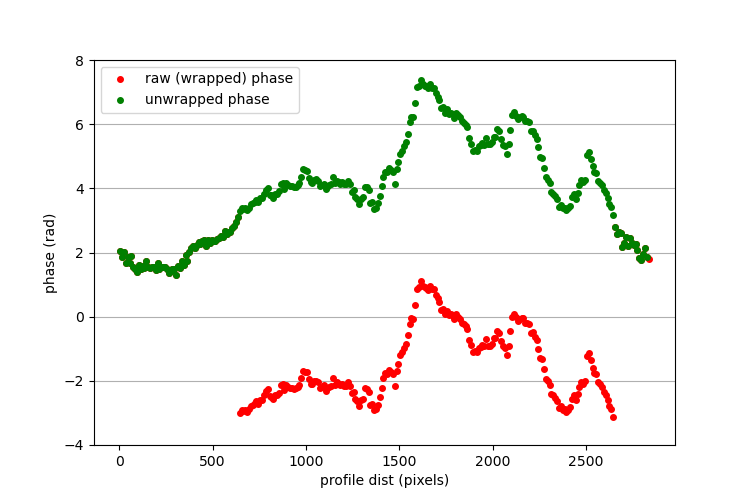

In [60]:
plt.figure(figsize=(7.5,5))
plt.plot(np.real(testResults[0]),np.angle(testResults[1]),'r.',markersize=8, label='raw (wrapped) phase')
plt.plot(np.real(unwrapped[0]),unwrapped[1],'g.',markersize=8,label='unwrapped phase')
plt.ylabel('phase (rad)'); plt.xlabel('profile dist (pixels)')
plt.legend(); plt.grid(axis='y'); plt.ylim(-4,8)
plt.show()